=== DATASET STRUCTURE CHECK ===

TRAIN SET:
  Matang     : 378 images
  Mentah     : 642 images

VALID SET:
  Matang     : 44 images
  Mentah     : 53 images

TEST SET:
  Matang     : 13 images
  Mentah     : 36 images
Found 1020 files belonging to 2 classes.
Found 97 files belonging to 2 classes.
Found 49 files belonging to 2 classes.

=== CLASS LABEL MAPPING ===
Label 0 -> Matang
Label 1 -> Mentah


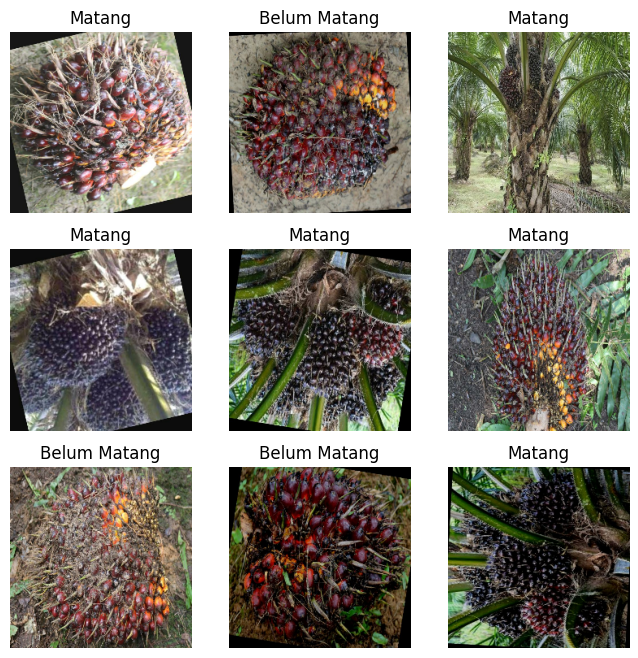


=== PIPELINE 2 OUTPUT ===
train_ds : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
val_ds   : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
test_ds  : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Pipeline 2 completed successfully.


In [2]:
# ============================================================
# PIPELINE 2: DATASET INITIALIZATION & STRUCTURE VALIDATION
# ============================================================

import os
import tensorflow as tf
import matplotlib.pyplot as plt

# ----------------------------
# 1. Global Configuration
# ----------------------------
DATASET_DIR = "/content/drive/MyDrive/MAKERINDO-TOR/Capstone-Januari/Klasifikasi-Sawit"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_dir = os.path.join(DATASET_DIR, "train")
val_dir   = os.path.join(DATASET_DIR, "valid")
test_dir  = os.path.join(DATASET_DIR, "test")

# ----------------------------
# 2. Dataset Structure Validation
# ----------------------------
print("=== DATASET STRUCTURE CHECK ===")
for split, path in {
    "TRAIN": train_dir,
    "VALID": val_dir,
    "TEST" : test_dir
}.items():
    print(f"\n{split} SET:")
    for cls in sorted(os.listdir(path)):
        cls_path = os.path.join(path, cls)
        img_count = len(os.listdir(cls_path))
        print(f"  {cls:<10} : {img_count} images")

# ----------------------------
# 3. Load Dataset
# ----------------------------
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    seed=SEED
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False
)

# ----------------------------
# 4. Label Mapping Validation
# ----------------------------
class_names = train_ds.class_names
print("\n=== CLASS LABEL MAPPING ===")
for idx, name in enumerate(class_names):
    print(f"Label {idx} -> {name}")

# ----------------------------
# 5. Dataset Sanity Check (Visualization)
# ----------------------------
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_text = "Matang" if labels[i] == 1 else "Belum Matang"
        plt.title(label_text)
        plt.axis("off")
plt.show()

# ----------------------------
# 6. Pipeline Output Summary
# ----------------------------
print("\n=== PIPELINE 2 OUTPUT ===")
print("train_ds :", train_ds)
print("val_ds   :", val_ds)
print("test_ds  :", test_ds)
print("Pipeline 2 completed successfully.")


In [3]:
# ============================================================
# PIPELINE 3: DATASET PERFORMANCE OPTIMIZATION
# ============================================================

import tensorflow as tf

# ----------------------------
# 1. Performance Configuration
# ----------------------------
AUTOTUNE = tf.data.AUTOTUNE
SHUFFLE_BUFFER_SIZE = 1000  # ideal ~ jumlah data train

# ----------------------------
# 2. Normalize Image Pixel Values
# ----------------------------
def normalize_images(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds_optimized = (
    train_ds
    .map(normalize_images, num_parallel_calls=AUTOTUNE)
    .shuffle(SHUFFLE_BUFFER_SIZE, seed=42)
    .cache()
    .prefetch(AUTOTUNE)
)

val_ds_optimized = (
    val_ds
    .map(normalize_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

test_ds_optimized = (
    test_ds
    .map(normalize_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .prefetch(AUTOTUNE)
)

# ----------------------------
# 3. Pipeline Validation
# ----------------------------
print("=== DATASET PIPELINE VALIDATION ===")
print("Train Dataset :", train_ds_optimized)
print("Valid Dataset :", val_ds_optimized)
print("Test Dataset  :", test_ds_optimized)

# ----------------------------
# 4. Sanity Check (Value Range)
# ----------------------------
for images, labels in train_ds_optimized.take(1):
    print("\n=== SANITY CHECK ===")
    print("Image min value :", tf.reduce_min(images).numpy())
    print("Image max value :", tf.reduce_max(images).numpy())
    print("Label sample    :", labels[:5].numpy())

=== DATASET PIPELINE VALIDATION ===
Train Dataset : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Valid Dataset : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>
Test Dataset  : <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

=== SANITY CHECK ===
Image min value : 0.0
Image max value : 1.0
Label sample    : [[1.]
 [1.]
 [0.]
 [0.]
 [1.]]


In [4]:
# ============================================================
# PIPELINE 4: MODEL ARCHITECTURE (TRANSFER LEARNING)
# ============================================================

import tensorflow as tf
from tensorflow.keras import layers, models

# ----------------------------
# 1. Model Configuration
# ----------------------------
IMG_SIZE = (224, 224, 3)
LEARNING_RATE = 1e-4

# ----------------------------
# 2. Load Pretrained Backbone
# ----------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE,
    include_top=False,
    weights="imagenet"
)

# Freeze backbone (feature extractor)
base_model.trainable = False

# ----------------------------
# 3. Build Classification Head
# ----------------------------
inputs = tf.keras.Input(shape=IMG_SIZE)

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(
    1,
    activation="sigmoid",
    name="output"
)(x)

model = models.Model(inputs, outputs)

# ----------------------------
# 4. Compile Model
# ----------------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall")
    ]
)

# ----------------------------
# 5. Model Summary
# ----------------------------
print("\n=== MODEL SUMMARY ===")
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

=== MODEL SUMMARY ===


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,385 (8.64 MB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 2,260,544 (8.62 MB)

In [7]:
# ============================================================
# PIPELINE 5: MODEL TRAINING & CALLBACKS
# ============================================================

import tensorflow as tf
import os

# ----------------------------
# 1. Training Configuration
# ----------------------------
EPOCHS = 20
BATCH_SIZE = 32

MODEL_DIR = "/content/drive/MyDrive/MAKERINDO-TOR/Capstone-Januari/models"
os.makedirs(MODEL_DIR, exist_ok=True)

MODEL_PATH = os.path.join(MODEL_DIR, "mobilenetv2_sawit_baseline.h5")

# ----------------------------
# 2. Callbacks Setup
# ----------------------------
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=MODEL_PATH,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

# ----------------------------
# 3. Model Training
# ----------------------------
print("\n=== START TRAINING ===")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

print("\n=== TRAINING COMPLETED ===")
print(f"Best model saved at: {MODEL_PATH}")



=== START TRAINING ===
Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8561 - loss: 0.3230 - precision: 0.8861 - recall: 0.8823
Epoch 1: val_loss improved from inf to 0.31359, saving model to /content/drive/MyDrive/MAKERINDO-TOR/Capstone-Januari/models/mobilenetv2_sawit_baseline.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.8560 - loss: 0.3230 - precision: 0.8859 - recall: 0.8823 - val_accuracy: 0.8557 - val_loss: 0.3136 - val_precision: 0.8421 - val_recall: 0.9057 - learning_rate: 1.0000e-04
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8711 - loss: 0.3000 - precision: 0.8800 - recall: 0.9218
Epoch 2: val_loss did not improve from 0.31359
32/32 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.8713 - loss: 0.2998 - precision: 0.8804 - recall: 0.9217 - val_accuracy: 0.8557 - val_loss: 0.3140 - val_precision: 0.8421 - val_recall: 0.9057 - learning_rate: 1.0000e-04
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8758 - loss: 0.2957 - precision: 0.8878 - recall: 0.9137
Epoch 3: val_loss improved from 0.31359 to 0.31244, saving model to /content/drive/MyDrive/MAKERINDO-TOR/Capstone-Januari/models/mobilenetv2_sawit_baseline.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 56s 2s/step - accuracy: 0.8756 - loss: 0.2960 - precision: 0.8878 - recall: 0.9136 - val_accuracy: 0.8557 - val_loss: 0.3124 - val_precision: 0.8421 - val_recall: 0.9057 - learning_rate: 1.0000e-04
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8785 - loss: 0.3034 - precision: 0.8977 - recall: 0.9069
Epoch 4: val_loss did not improve from 0.31244
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.8785 - loss: 0.3034 - precision: 0.8979 - recall: 0.9068 - val_accuracy: 0.8660 - val_loss: 0.3135 - val_precision: 0.8448 - val_recall: 0.9245 - learning_rate: 1.0000e-04
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8413 - loss: 0.3443 - precision: 0.8650 - recall: 0.8830
Epoch 5: val_loss did not improve from 0.31244
32/32 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8417 - loss: 0.3436 - precision: 0.8657 - recall: 0.8830 - val_accuracy: 0.8660 - val_loss: 0.3143 - val_precision: 0.8448 - val_recall: 0.9245 - learning_rate: 1.


=== TEST SET EVALUATION ===
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9039 - loss: 0.2371 - precision: 0.9608 - recall: 0.8918
Test Loss      : 0.2119
Test Accuracy  : 0.9184
Test Precision : 0.9706
Test Recall    : 0.9167
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


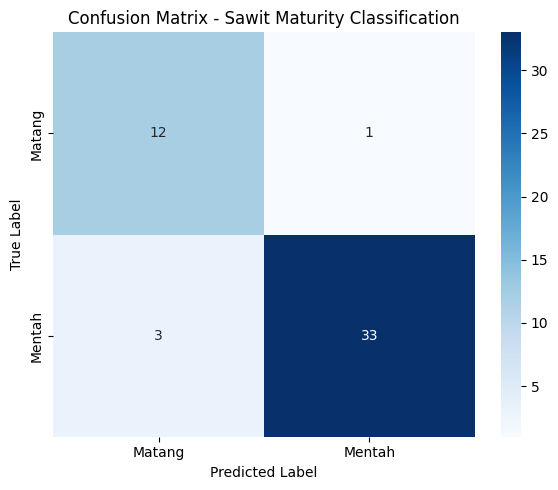


=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

      Matang       0.80      0.92      0.86        13
      Mentah       0.97      0.92      0.94        36

    accuracy                           0.92        49
   macro avg       0.89      0.92      0.90        49
weighted avg       0.93      0.92      0.92        49



In [8]:
# ============================================================
# PIPELINE 6: MODEL EVALUATION (TEST SET)
# ============================================================

import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1. Evaluate on Test Dataset
# ----------------------------
print("\n=== TEST SET EVALUATION ===")

test_loss, test_acc, test_precision, test_recall = model.evaluate(
    test_ds,
    verbose=1
)

print(f"Test Loss      : {test_loss:.4f}")
print(f"Test Accuracy  : {test_acc:.4f}")
print(f"Test Precision : {test_precision:.4f}")
print(f"Test Recall    : {test_recall:.4f}")

# ----------------------------
# 2. Get Predictions
# ----------------------------
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy().flatten())
    y_pred.extend((preds > 0.5).astype(int).flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ----------------------------
# 3. Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Matang", "Mentah"],
    yticklabels=["Matang", "Mentah"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Sawit Maturity Classification")
plt.tight_layout()
plt.show()

# ----------------------------
# 4. Classification Report
# ----------------------------
print("\n=== CLASSIFICATION REPORT ===")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=["Matang", "Mentah"]
    )
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


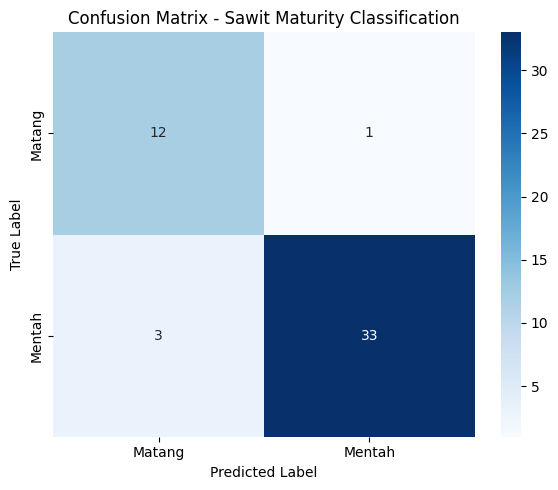

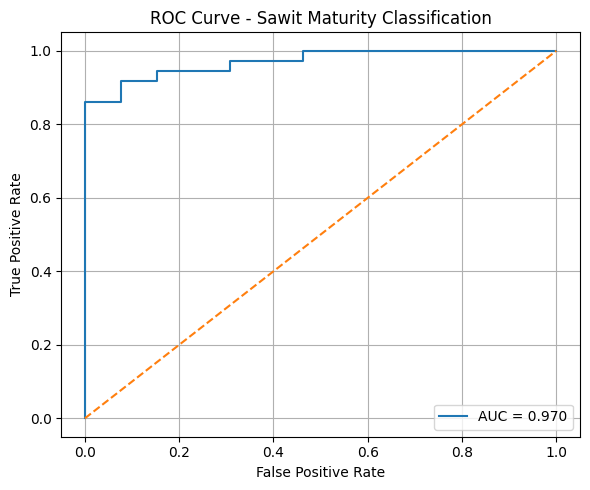

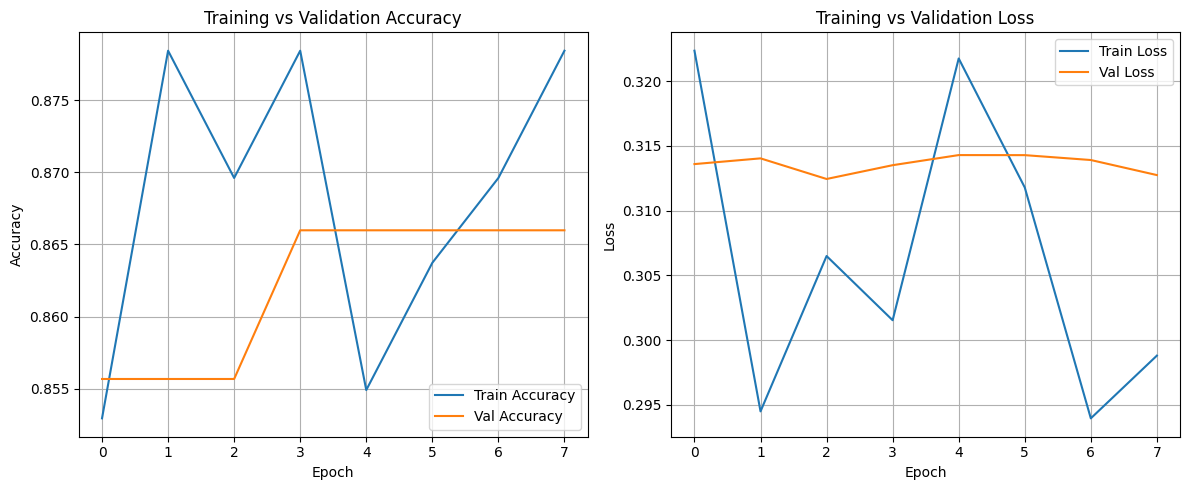

In [9]:
# ============================================================
# VISUALIZATION: MODEL EVALUATION
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# ----------------------------
# 1. Get Ground Truth & Probabilities
# ----------------------------
y_true = []
y_prob = []

for images, labels in test_ds:
    probs = model.predict(images)
    y_true.extend(labels.numpy().flatten())
    y_prob.extend(probs.flatten())

y_true = np.array(y_true)
y_prob = np.array(y_prob)
y_pred = (y_prob > 0.5).astype(int)

# ----------------------------
# 2. Confusion Matrix
# ----------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Matang", "Mentah"],
    yticklabels=["Matang", "Mentah"]
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Sawit Maturity Classification")
plt.tight_layout()
plt.show()

# ----------------------------
# 3. ROC Curve & AUC
# ----------------------------
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Sawit Maturity Classification")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------------------------
# 4. Training History (Loss & Accuracy)
# ----------------------------
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
# ===============================
# SAVE CLASS MAPPING
# ===============================
import json
import os

CLASS_MAPPING_PATH = f"{MODEL_DIR}/class_mapping.json"

class_mapping = {
    "0": "Matang",
    "1": "Mentah"
}

with open(CLASS_MAPPING_PATH, "w") as f:
    json.dump(class_mapping, f, indent=4)

print(f"Class mapping saved at: {CLASS_MAPPING_PATH}")


Class mapping saved at: /content/drive/MyDrive/MAKERINDO-TOR/Capstone-Januari/models/class_mapping.json


Model loaded successfully
Class Mapping: {0: 'Matang', 1: 'Mentah'}


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


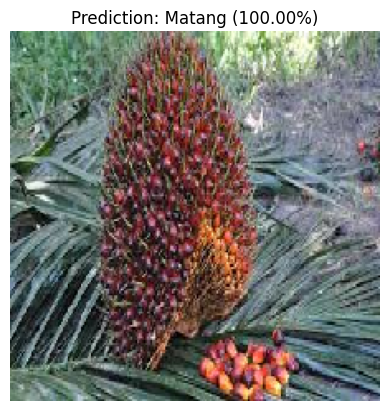

=== INFERENCE RESULT ===
Predicted Class : 0
Label           : Matang
Confidence      : 1.0000


In [16]:
# ================================
# PIPELINE 6: INFERENCE PIPELINE
# WITH CLASS MAPPING
# ================================

import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# -------------------------------
# PATH CONFIG
# -------------------------------
MODEL_PATH = "/content/drive/MyDrive/MAKERINDO-TOR/Capstone-Januari/models/mobilenetv2_sawit_baseline.h5"
CLASS_MAPPING_PATH = "/content/drive/MyDrive/MAKERINDO-TOR/Capstone-Januari/models/class_mapping.json"
IMAGE_PATH = "/content/sawit-1.jfif"

IMG_SIZE = (224, 224)

# -------------------------------
# LOAD MODEL
# -------------------------------
model = tf.keras.models.load_model(MODEL_PATH)
print("Model loaded successfully")

# -------------------------------
# LOAD CLASS MAPPING
# -------------------------------
with open(CLASS_MAPPING_PATH, "r") as f:
    class_mapping = json.load(f)

# convert key ke int
class_mapping = {int(k): v for k, v in class_mapping.items()}
print("Class Mapping:", class_mapping)

# -------------------------------
# IMAGE PREPROCESSING FUNCTION
# -------------------------------
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=IMG_SIZE)
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array, img

# -------------------------------
# LOAD & PREPROCESS IMAGE
# -------------------------------
input_image, original_img = preprocess_image(IMAGE_PATH)

# -------------------------------
# MODEL PREDICTION
# -------------------------------
prediction = model.predict(input_image)[0][0]

# binary classification threshold
predicted_class = 1 if prediction >= 0.5 else 0
confidence = prediction if predicted_class == 1 else 1 - prediction

label = class_mapping[predicted_class]

# -------------------------------
# DISPLAY RESULT
# -------------------------------
plt.imshow(original_img)
plt.axis("off")
plt.title(f"Prediction: {label} ({confidence*100:.2f}%)")
plt.show()

print("=== INFERENCE RESULT ===")
print(f"Predicted Class : {predicted_class}")
print(f"Label           : {label}")
print(f"Confidence      : {confidence:.4f}")



In [18]:
# ===============================
# SAVE TRAINED MODEL (KERAS)
# ===============================
MODEL_DIR = "/content/drive/MyDrive/MAKERINDO-TOR/Capstone-Januari/models"
MODEL_NAME = "mobilenetv2_sawit_baseline.keras"

model_save_path = f"{MODEL_DIR}/{MODEL_NAME}"

model.save(model_save_path)

print(f"Model saved successfully at: {model_save_path}")


Model saved successfully at: /content/drive/MyDrive/MAKERINDO-TOR/Capstone-Januari/models/mobilenetv2_sawit_baseline.keras


/content
